In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Libraries and imports



In [2]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=550737 sha256=af9e9b2e536a10a4ab850e9022f6adbd40a7ce53d85d75481b42916463cf212f
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [3]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.3 MB/s eta 0:00:00


In [4]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.5 MB/s eta 0:00:00


In [5]:
!pip install --upgrade tensorflow-hub

In [6]:
import tensorflow as tf
import numpy as np
import os
import random
import string
import re
import matplotlib.pyplot as plt
import keras.backend as K
import pandas as pd
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as tftx
import json

tfk = tf.keras
tfkl = tf.keras.layers
tf.config.optimizer.set_jit(True)
strategy = tf.distribute.get_strategy()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Random seed for reproducibility

In [7]:
seed = 21
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Mixed precision


In [8]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else:
  policyConfig = 'mixed_float16'
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)

# Parameters

In [9]:
# Parameters

batch_size = 32
image_shape = (128, 128, 3)

# Train, Validation & Test Dataset

In [10]:
!unzip "/gdrive/My Drive/val2014_128.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: val2014_128/COCO_val2014_000000510343.jpg  
  inflating: val2014_128/COCO_val2014_000000510351.jpg  
  inflating: val2014_128/COCO_val2014_000000510358.jpg  
  inflating: val2014_128/COCO_val2014_000000510383.jpg  
  inflating: val2014_128/COCO_val2014_000000510395.jpg  
  inflating: val2014_128/COCO_val2014_000000510449.jpg  
  inflating: val2014_128/COCO_val2014_000000510515.jpg  
  inflating: val2014_128/COCO_val2014_000000510527.jpg  
  inflating: val2014_128/COCO_val2014_000000510548.jpg  
  inflating: val2014_128/COCO_val2014_000000510559.jpg  
  inflating: val2014_128/COCO_val2014_000000510579.jpg  
  inflating: val2014_128/COCO_val2014_000000510585.jpg  
  inflating: val2014_128/COCO_val2014_000000510587.jpg  
  inflating: val2014_128/COCO_val2014_000000510593.jpg  
  inflating: val2014_128/COCO_val2014_000000510606.jpg  
  inflating: val2014_128/COCO_val2014_000000510609.jpg  
  inflating: val2014_128/COCO_val2014_

In [11]:
with open('/gdrive/My Drive/instances_val2014.json', 'r') as file:
    instances_train2014 = json.load(file)

categories={}
for c in instances_train2014["categories"]:
    categories[c["id"]]=c["name"]

inverse_categories={}
for c in instances_train2014["categories"]:
    inverse_categories[c["name"]]=c["id"]

name_images = set()

for l in instances_train2014["annotations"]:
    name_images.add(l["image_id"])

labels={}
for n in name_images:
    labels[n]=set()

for lab in instances_train2014["annotations"]:
    labels[lab["image_id"]].add(categories[lab["category_id"]])

path_folder_images = "/content/val2014_128/COCO_val2014_"
image_extension = ".jpg"

temp = []
for n in name_images:
  if len(labels[n]) == 1:
    temp.append(n)

name_images = list(map(lambda x: path_folder_images + (str(x).zfill(12)) + image_extension, temp))

In [12]:
def load_image(name_image):
    image = tf.io.read_file(name_image)
    image = tf.image.decode_jpeg(image, channels=3)
    image /= 255
    return image, name_image

def make_ds(name_image):
    return tf.data.Dataset.from_tensor_slices(name_image) \
        .map(load_image) \
        .batch(1, drop_remainder=False)

ds = make_ds(name_images)

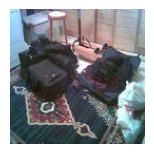

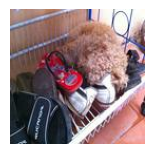

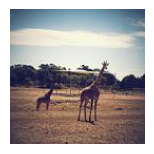

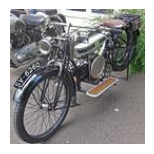

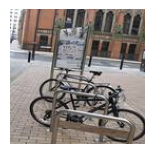

In [13]:
for i,o in ds.take(5):
  plt.figure(figsize=(8, 8))
  for index in range(1):
      plt.subplot(2, 4, index+1)
      plt.imshow(i[index], cmap='gray')
      plt.axis('off')

  plt.show()

# Load Encoders

In [14]:
image_encoder=tf.keras.models.load_model("/gdrive/MyDrive/test_image_weights_epoch_3")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: vit_keras.vit is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: vit_keras.layers is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [15]:
caption_encoder=tf.keras.models.load_model("/gdrive/MyDrive/test_caption_weights_epoch_3")

#Zero Shot Classification




## Label Embeddings

In [16]:
labels_embed = []
label_indices = []
for c in categories:
  labels_embed.append(caption_encoder.predict([categories[c]]))
  label_indices.append(c)

1/1 [==============================] - 0s 48ms/step


In [17]:
from annoy import AnnoyIndex

# Create an Annoy index
num_trees = 10  # Number of trees in the index
annoy_index = AnnoyIndex(768)  # Provide the dimension of your embeddings

# Add embeddings to the index
for i, embedding in enumerate(labels_embed):
    annoy_index.add_item(label_indices[i], embedding[0])

# Build the index
annoy_index.build(num_trees)

<ipython-input-17-3c84c31b320b>:5: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  annoy_index = AnnoyIndex(768)  # Provide the dimension of your embeddings


True

## Query embedding & Retrieval


In [18]:
true_labels = []
predicted_labels = []
for i,o in ds:
  img_embed = image_encoder.predict(i)

  # Query the index to find nearest neighbors
  num_neighbors = len(name_images) # Number of neighbors to retrieve
  nearest_indices = annoy_index.get_nns_by_vector(img_embed[0], 1, search_k=-1)
  predicted_labels.append(nearest_indices[0])

  true_labels.append(inverse_categories[(str(labels[int(str(o[0].numpy())[40:-5])])[2:-2])])


Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 23ms/step


In [19]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=list(inverse_categories.keys()))

# Print the classification report
print(report)


                precision    recall  f1-score   support

        person       0.57      0.12      0.20       134
       bicycle       0.41      0.45      0.43        31
           car       0.05      0.03      0.04        59
    motorcycle       0.79      0.69      0.74        87
      airplane       0.94      0.73      0.82       421
           bus       0.70      0.58      0.63        95
         train       0.96      0.80      0.88       454
         truck       0.68      0.57      0.62       125
          boat       0.60      0.72      0.66       167
 traffic light       0.47      0.72      0.57       179
  fire hydrant       0.79      0.61      0.69       169
     stop sign       0.79      0.73      0.75       193
 parking meter       0.33      0.41      0.37        39
         bench       0.48      0.65      0.55       182
          bird       0.82      0.56      0.66       483
           cat       0.66      0.46      0.54       188
           dog       0.40      0.49      0.44  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
